In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


!ls "/content/drive/MyDrive/STA457_Project"

Mounted at /content/drive
a.ipynb		       Ghana_data.csv	   monthly_aggregated_data.csv
arimax.ipynb	       IV_data.csv	   Monthly_Average_Cocoa_Prices.csv
Daily_Prices_ICCO.csv  main.ipynb	   three_day_aggregated_data.csv
DataAggregation.ipynb  main_monthly.ipynb  weekly_aggregated_data.csv
final.csv	       main_weekly.ipynb   weekly_with_usd_open.csv


## Data Preprocessing

In [ ]:
import pandas as pd

prices_df = pd.read_csv("/content/drive/MyDrive/STA457_Project/Daily_Prices_ICCO.csv",
                        parse_dates=["Date"],
                        dayfirst=True)

prices_df.rename(columns={"ICCO daily price (US$/tonne)": "price"}, inplace=True)

# convert 'price' from strings with commas to float
prices_df["price"] = (prices_df["price"]
                        .replace({",": ""}, regex=True)
                        .astype(float))

# set date as index for resampling
prices_df.set_index("Date", inplace=True)

# aggregate on weekly level
weekly_price = prices_df.resample("W").mean()


# Côte d’Ivoire weather data
ci_df = pd.read_csv("/content/drive/MyDrive/STA457_Project/IV_data.csv", parse_dates=["DATE"])
ci_df.set_index("DATE", inplace=True)

# clean and drop columns we dont want
for col in ["PRCP", "TAVG", "TMAX", "TMIN"]:
    if col in ci_df.columns:
        ci_df[col] = pd.to_numeric(ci_df[col], errors="coerce")

# aggregate temperature by mean and precipitation by weekly sum
weekly_ci = ci_df.resample("W").agg({
    "PRCP": "sum",
    "TAVG": "mean",
    "TMAX": "mean",
    "TMIN": "mean"
})

# rename columns to indicate these are from Côte d’Ivoire
weekly_ci.rename(columns={
    "PRCP": "PRCP_CI",
    "TAVG": "TAVG_CI",
    "TMAX": "TMAX_CI",
    "TMIN": "TMIN_CI"
}, inplace=True)

# Ghana weather data
gh_df = pd.read_csv("/content/drive/MyDrive/STA457_Project/Ghana_data.csv", parse_dates=["DATE"])
gh_df.set_index("DATE", inplace=True)

# convert PRCP, TAVG, TMAX, TMIN to numeric
for col in ["PRCP", "TAVG", "TMAX", "TMIN"]:
    if col in gh_df.columns:
        gh_df[col] = pd.to_numeric(gh_df[col], errors="coerce")

# aggregate temperature by mean and precipitation by weekly sum
weekly_gh = gh_df.resample("W").agg({
    "PRCP": "sum",
    "TAVG": "mean",
    "TMAX": "mean",
    "TMIN": "mean"
})

# rename columns to indicate these are from Ghana
weekly_gh.rename(columns={
    "PRCP": "PRCP_GH",
    "TAVG": "TAVG_GH",
    "TMAX": "TMAX_GH",
    "TMIN": "TMIN_GH"
}, inplace=True)

print("Prices date range:", prices_df.index.min(), prices_df.index.max())
print("CI date range:", ci_df.index.min(), ci_df.index.max())
print("GH date range:", gh_df.index.min(), gh_df.index.max())


# combine data
weekly_all = weekly_price.join([weekly_ci, weekly_gh], how="inner")

# filling missing values with the mean of the respective columns
weekly_all.fillna(weekly_all.mean(), inplace=True)

weekly_all = weekly_all.reset_index()
weekly_all.rename(columns={'index': 'date'}, inplace=True)

print(weekly_all.head(10))

# save csv
weekly_all.to_csv("/content/drive/MyDrive/STA457_Project/weekly_aggregated_data.csv", index=False)

## Model

X_seq shape: (1580, 7, 9)
y_seq shape: (1580,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 50)                  │          12,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,051 (47.07 KB)

 Trainable params: 12,051 (47.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - val_loss: 0.0060
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 12/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - val_l

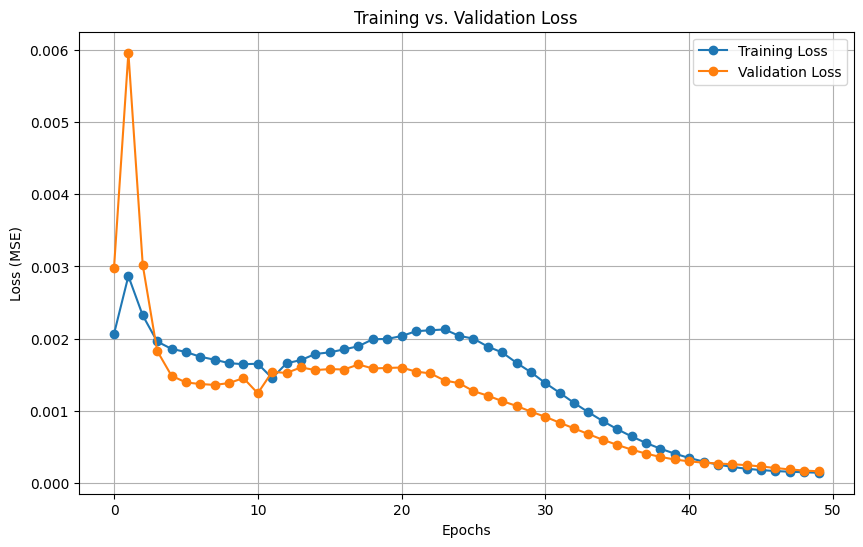

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


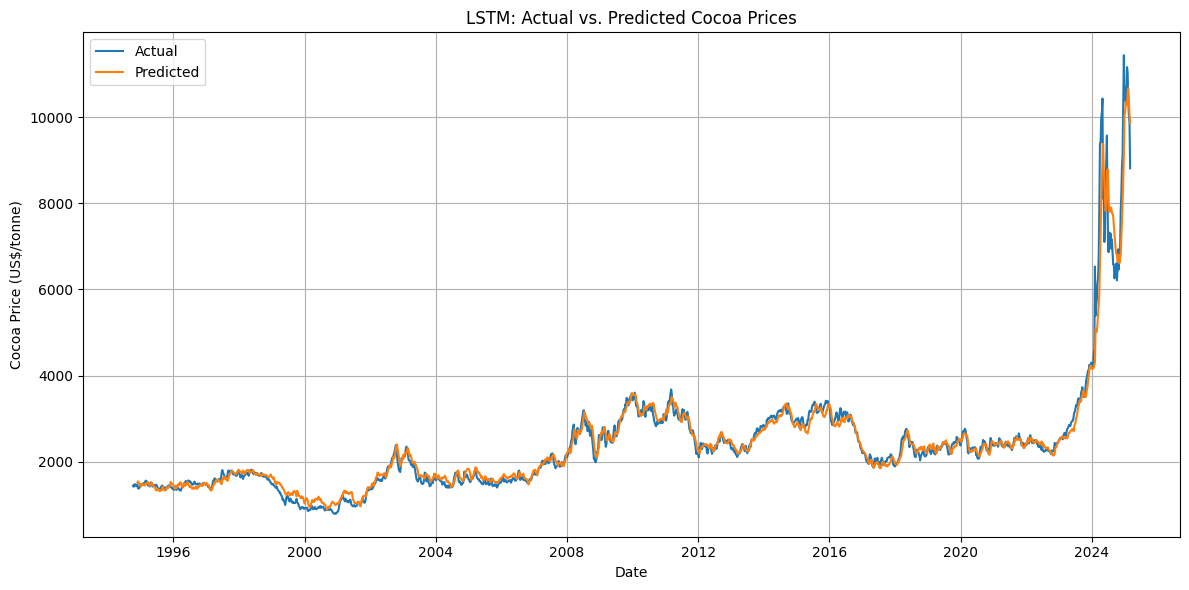

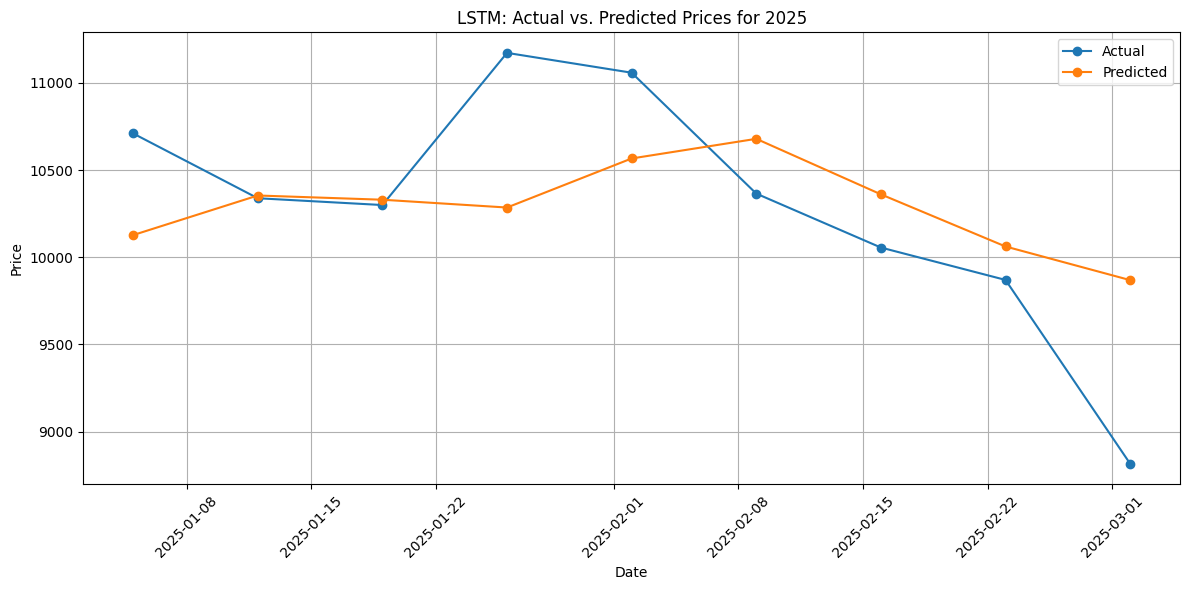

Test RMSE: 482.37
Test MAE: 237.35
Test MAPE: 4.76%
Test R²: 0.95
Predicted Cocoa Prices for 2025:
           date     Predicted
1578 2025-01-05  10127.032085
1579 2025-01-12  10353.870734
1580 2025-01-19  10329.655710
1581 2025-01-26  10284.918058
1582 2025-02-02  10566.098019
1583 2025-02-09  10678.711321
1584 2025-02-16  10360.536871
1585 2025-02-23  10061.669502
1586 2025-03-02   9868.875744


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# load data
df = pd.read_csv('/content/drive/MyDrive/STA457_Project/weekly_aggregated_data.csv')
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)
df.reset_index(drop=True, inplace=True)

# define the feature columns
feature_cols = ['price', 'PRCP_GH', 'TAVG_GH', 'TMAX_GH', 'TMIN_GH',
                'PRCP_CI', 'TAVG_CI', 'TMAX_CI', 'TMIN_CI']
data = df[feature_cols].values

# scale and standarize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# create sequences with a sliding window
lookback = 7

X_seq = []
y_seq = []
for i in range(lookback, len(scaled_data)):
    X_seq.append(scaled_data[i - lookback : i, :])
    y_seq.append(scaled_data[i, 0])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# print out to check the dimensions before putting into the model
print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)

# split the data for training and testing
train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# build and train model
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(lookback, X_seq.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    shuffle=False
)

# generate predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# helper function to inverse-transform predictions back to original scale
def inverse_transform_price(scaled_vals):
    """
    Utility to inverse-transform only the 'price' column,
    which is index 0 in feature_cols.
    """
    dummy = np.zeros((len(scaled_vals), len(feature_cols)))
    dummy[:, 0] = scaled_vals.flatten()
    inv = scaler.inverse_transform(dummy)
    return inv[:, 0]

train_pred_inv = inverse_transform_price(train_pred)
y_train_inv = inverse_transform_price(y_train.reshape(-1, 1))

test_pred_inv = inverse_transform_price(test_pred)
y_test_inv = inverse_transform_price(y_test.reshape(-1, 1))

# training loss vs validation loss plot
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# combine train + test predictions into one array
all_predictions = np.empty(len(df))
all_predictions[:] = np.nan

# fill training predictions
# correspond to df indices [lookback .. lookback + train_size - 1]
for i in range(train_size):
    all_predictions[i + lookback] = train_pred_inv[i]

# create rolling window to perform the multi-step prediction
# correspond to df indices [lookback + train_size .. lookback + train_size + len(X_test) - 1]
for i in range(len(X_test)):
    all_predictions[i + lookback + train_size] = test_pred_inv[i]

df['Predicted'] = all_predictions

# shape: (lookback=7, num_features)
last_7_weeks_data = scaled_data[-lookback:, :]
current_window = last_7_weeks_data

all_preds = []
forecast_horizon = 8

for _ in range(forecast_horizon):
    # reshape for LSTM: (1, lookback, num_features)
    input_seq = current_window[np.newaxis, :, :]
    pred = model.predict(input_seq)
    # pred is one-step-ahead price

    all_preds.append(pred[0, 0])  # store the prediction

    # Now create a new row for the next time step
    new_row = np.copy(current_window[-1])  # start with last row’s features
    new_row[0] = pred[0, 0]                # update the price feature with your predicted value
    # Shift the window forward
    current_window = np.vstack([current_window[1:], new_row])

# in-sample prediction plot
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['price'], label='Actual')
plt.plot(df['date'], df['Predicted'], label='Predicted')
plt.title('LSTM: Actual vs. Predicted Cocoa Prices')
plt.xlabel('Date')
plt.ylabel('Cocoa Price (US$/tonne)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# out-of-sample prediction plot
df_2025 = df[(df['date'] >= '2025-01-01') & (df['date'] < '2026-01-01')]
plt.figure(figsize=(12, 6))
plt.plot(df_2025['date'], df_2025['price'], label='Actual', marker='o')
plt.plot(df_2025['date'], df_2025['Predicted'], label='Predicted', marker='o')
plt.title('LSTM: Actual vs. Predicted Prices for 2025')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# evaluation metrics
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test_inv, test_pred_inv))
mae = mean_absolute_error(y_test_inv, test_pred_inv)
mape = np.mean(np.abs((y_test_inv - test_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, test_pred_inv)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test R²: {r2:.2f}")

print("Predicted Cocoa Prices for 2025:")
print(df_2025[['date', 'Predicted']])
